In [20]:
import math
import random
import torch


class value:
    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        
        return f"The value is -> {self.data}"
    def __add__(self,other):
        other=other if isinstance (other,value) else value(other)
        out=value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad+=1+out.grad
        out._backward=_backward
        return out
    def __radd__(self,other):
        return self+other
    def __mul__(self, other):
        other = other if isinstance(other, value) else value(other)
        out = value(self.data * other.data,(self,other),'*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    def __rmul__(self,other):
        return self*other
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=value(t,(self,),'tanh')
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out
    def __truediv__(self,other):
        other=other if isinstance (other,value) else value(other)
        out=self.data/other.data
        return out
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    def exp(self):
        x = self.data
        out = value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

In [21]:
x1 = value(2.0, label='x1')
x2 = value(3.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

In [22]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

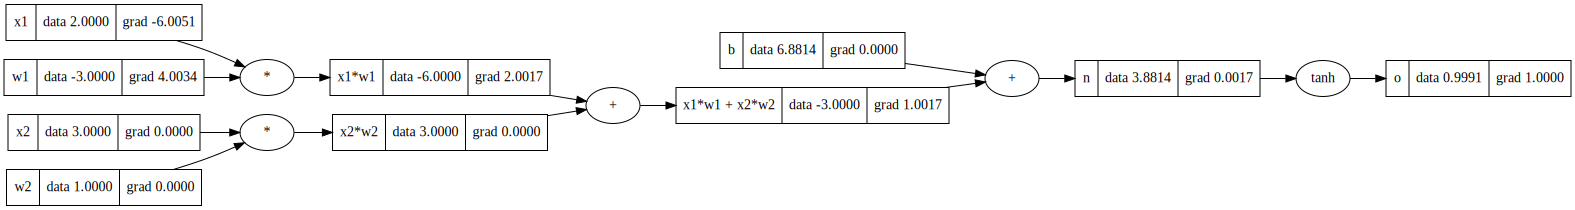

In [23]:
draw_dot(o)

In [24]:
x1=torch.Tensor([2.0]).double();x1.requires_grad=True
x2=torch.Tensor([2.0]).double();x2.requires_grad=True
w1=torch.Tensor([2.0]).double();w1.requires_grad=True
w2=torch.Tensor([2.0]).double();w2.requires_grad=True
b=torch.Tensor([6.24352]).double();x1.requires_grad=True
n=x1*w1 + x2*w2 +b
o=torch.tanh(n)
o.item()
o.backward()
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

3.398614722982529e-12
3.398614722982529e-12
3.398614722982529e-12
3.398614722982529e-12


In [67]:
class Neuron:
    
    def __init__(self,nin):
        self.w= [value(random.uniform(-1,1)) for _ in range(nin)]
        self.b= value(random.uniform(-1,1))
        
    def __call__(self,x):
        act=sum((x1*w1 for x1,w1 in zip(self.w,x)),self.b)
        out=act.tanh()
        return out        
class layer:
    
    def __init__(self,nin,nout):
        self.neuron= [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs=[n(x) for n in self.neuron]
        return outs[0] if len(outs) == 1 else outs
class mlp:
    
    def __init__(self,nin,nouts):
        sz=[nin]+nouts
        self.layers=[layer(sz[i],sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for l in self.layers:
            x=l(x)
        return x


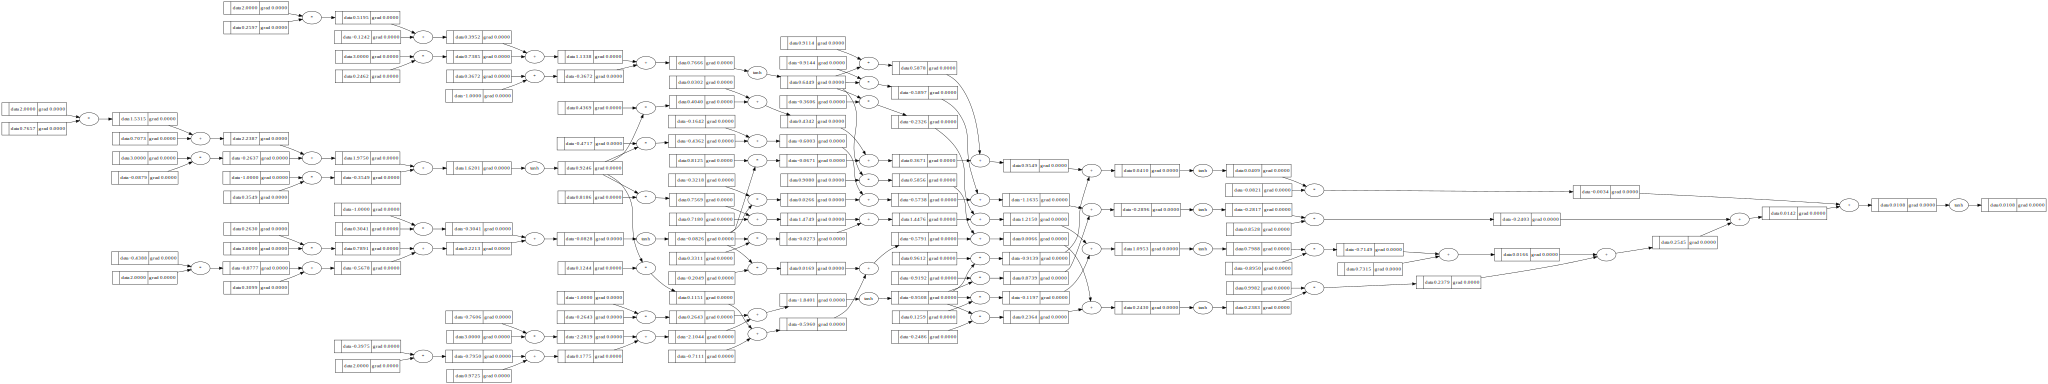

In [68]:
x = [2.0, 3.0, -1.0]
n = mlp(3, [4, 4, 1])
n(x)
draw_dot(n(x))